# Capstone Project - The Battle of Neighborhoods

### Find the best sushi restaurant in New York City

New York City is the is the largest city in the United States, and is a large and ethnically diverse metropolis. In 2017, New York City had a population of 8,622,698 people. The diverse culture of NYC makes it a great place for different and high quality restaurants.

My wife and I are big fans of Japanese cuisine, especially sushi. In every city we go, we have to try at least one sushi restaurant. Sadley, my favorite sushi restaurant in NYC has been closed. In this project, I want to find the best sushi restaurant for us to visit on our next trip to NYC.

### Data

The following data is used in the project:<br/>
1 - Boroughs and Neighborhoods in NYC:  https://cocl.us/new_york_dataset <br/>
2 - Sushi resturants from Foursquare API  <br/>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [89]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

Download the data

In [2]:
import urllib.request
urllib.request.urlretrieve("https://cocl.us/new_york_dataset", 'newyork_data.json')
print('Data downloaded!')

Data downloaded!


In [27]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Define a new variable that includes the key data, and transform it into a pandas df.

In [28]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Now let's examine the data

### Methodology

I will analyze and visulaize the data to find the best restaurant. I will collect data from foursquare that include ratings for the restaurnts to help me in the selection process 

In [29]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

Next, we use geopy library to get the latitude and longitude values of New York City.

In [30]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


Now we can create a map for NYC

In [7]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_newyork)  
    
map_newyork

The next part of this project is to collect data from Foursquare

Before we proceed, let's define some functions to help us collect the data

In [196]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&
        client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'
        .format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            v['venue']['id'],
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'id',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now let's found all venues in NYC for each Neighborhood (limit = 100)

In [133]:
LIMIT = 100
ny_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

In [134]:
ny_venues.head()

Neighborhood                        id  Neighborhood Latitude  \
0    Wakefield  4c537892fd2ea593cb077a28              40.894705   
1    Wakefield  4d375ce799fe8eec99fd2355              40.894705   
2    Wakefield  4c10f6aece57c92804a682d2              40.894705   
3    Wakefield  4c9e50e38afca09379b2ff15              40.894705   
4    Wakefield  4d6af9426107f04dedeb297a              40.894705   

   Neighborhood Longitude                        Venue  Venue Latitude  \
0              -73.847201             Lollipops Gelato       40.894123   
1              -73.847201           Ripe Kitchen & Bar       40.898152   
2              -73.847201  Jackie's West Indian Bakery       40.889283   
3              -73.847201              Ali's Roti Shop       40.894036   
4              -73.847201                     Rite Aid       40.896649   

   Venue Longitude        Venue Category  
0       -73.845892          Dessert Shop  
1       -73.838875  Caribbean Restaurant  
2       -73.843310  Caribbean Restaurant  
3       -73.856935  Caribbean Restaurant  
4       -73.844846              Pharmacy

Now we collect the Sushi Resturants

In [374]:
sushi_rest = ny_venues[ny_venues['Venue Category']=="Sushi Restaurant"].reset_index(drop=True).drop_duplicates(subset=['id'], keep='first')
sushi_rest.head()

Neighborhood                        id  Neighborhood Latitude  \
0        Fieldston  5500e02c498e2814defb4877              40.895437   
1   Pelham Parkway  4c45c922f97fbe9a9e02bd30              40.857413   
2     Country Club  4bbfc5a974a9a5935519cff6              40.844246   
4      Morris Park  4e25c5e0483bbcc48dc8531d              40.847549   
5  North Riverdale  4baa9c97f964a52088793ae3              40.908543   

   Neighborhood Longitude                   Venue  Venue Latitude  \
0              -73.905643             Asian Tokyo       40.890839   
1              -73.854756  Kiraku Hibachi & Sushi       40.853356   
2              -73.824099                 Sushi Q       40.844242   
4              -73.850402              Namü Sushi       40.854082   
5              -73.904531             Tokyo House       40.905672   

   Venue Longitude    Venue Category  
0       -73.898335  Sushi Restaurant  
1       -73.853629  Sushi Restaurant  
2       -73.830526  Sushi Restaurant  
4       -73.843581  Sushi Restaurant  
5       -73.904309  Sushi Restaurant

Now let us see how many restaurants did we collect

In [375]:
sushi_rest.shape

(160, 8)

We have 160 restaurants, let's see them

In [376]:
map_newyork_sushi = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, ven in zip(sushi_rest['Venue Latitude'], sushi_rest['Venue Longitude'], sushi_rest['Venue']):
    label = folium.Popup(str(ven), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_newyork_sushi)  
    
map_newyork_sushi

Let's see how many restaurants are there by Borough

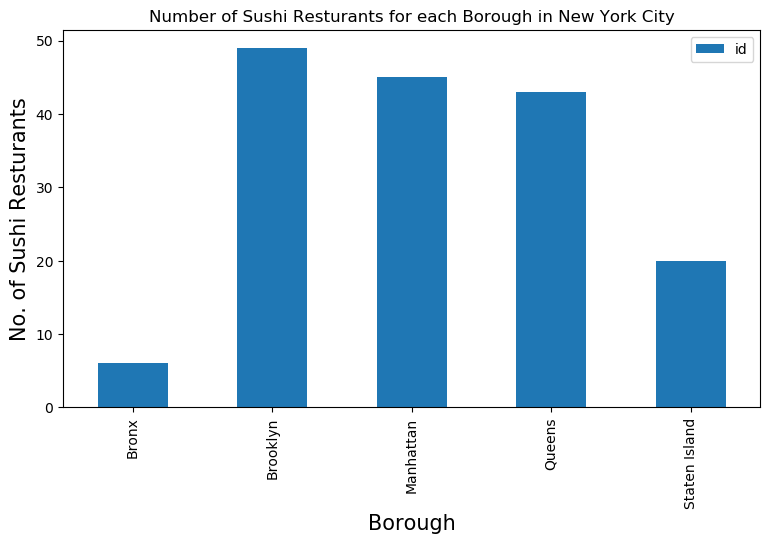

In [377]:
# First add the borough name by merging
sushi_rest_b = pd.merge(sushi_rest, neighborhoods[["Neighborhood","Borough"]]  , on='Neighborhood')
# Then we plot
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Sushi Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No. of Sushi Resturants', fontsize=15)
#giving a bar plot
sushi_rest_b.groupby('Borough')['id'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Brooklyn has the highest number of sushi restaurant. Staten Islan and Bronx have few sushi restaurants 

Now let's see how many restaurants per neighborhood (I will only take neighborhoods with more than 2 sushi restaurants)

In [378]:
per_N = sushi_rest_b.groupby('Neighborhood')['Venue'].count().reset_index(name="count")
per_N.sort_values('count', ascending=False ).head(10)

Neighborhood  count
79     Sheepshead Bay      5
80           Steinway      5
50  Manhattan Terrace      5
46         Lenox Hill      4
26        Eltingville      4
95          Yorkville      3
83            Tribeca      3
37   Hamilton Heights      3
77   Roosevelt Island      3
72   Prospect Heights      3

Now let's collect the ratings, number of reviewers, and number of likes

In [379]:
sushi_rest_b["Rating"] = np.nan
sushi_rest_b["Likes"] = np.nan
sushi_rest_b["No. of Ratings"] = np.nan
venue_data = []

In [ ]:
for i in range(0,len(sushi_rest_b)):
    ID = sushi_rest_b['id'][i]
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        ID,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    # continue in case any information is not available
    try:
        sushi_rest_b["Likes"][i] =venue_data['likes']['count']
    except KeyError:
        pass
    try:
        sushi_rest_b["Rating"][i] = venue_data['rating']
        sushi_rest_b["No. of Ratings"][i] = venue_data['ratingSignals']
    except KeyError:
        pass

### Results and Discussions

I will examine the highest rated restaurants in this section

In [390]:
sushi_rest_b.sort_values('Rating', ascending=False ).reset_index(drop=True)

Neighborhood                        id  \
0                     Flatiron  5a0e475b018cbb6a2196479e   
1                   Lenox Hill  501adf11e4b0d225f8788a03   
2                 West Village  52155e9d11d2c369404df14e   
3                      Chelsea  49d991d9f964a5204a5e1fe3   
4                      Chelsea  49d991d9f964a5204a5e1fe3   
5            Greenwich Village  45ac12d6f964a5205d411fe3   
6                      Midtown  595ebd0aee712007dc5ae215   
7                  Murray Hill  450972f5f964a5203d391fe3   
8            Greenwich Village  555e7399498eccd4b34fe416   
9                 Williamsburg  423e0e80f964a52048201fe3   
10            Prospect Heights  532f5fd3498e2f7f41aab662   
11                 Murray Hill  450972f5f964a5203d391fe3   
12                     Tribeca  4a8f2f39f964a520471420e3   
13            Prospect Heights  49f50c9ff964a5208a6b1fe3   
14                     Astoria  4a3ee04cf964a52083a31fe3   
15              Lincoln Square  4ea75442f7903beac0782454   
16                     Midtown  4249ec00f964a52093201fe3   
17                        Noho  5c2d4603464d6500395e552d   
18              Lincoln Square  4a20a2e9f964a520af7c1fe3   
19                     Tribeca  4aad744bf964a520606020e3   
20                    Steinway  46fcdefaf964a520114b1fe3   
21                    Downtown  49e63b62f964a52027641fe3   
22                    Woodside  4a6f1c00f964a52054d51fe3   
23                Forest Hills  4b58ed76f964a520967328e3   
24                   Yorkville  414e1d80f964a520f11c1fe3   
25              Lincoln Square  591b6df695d986522a5ddd50   
26                East Village  3fd66200f964a52023e51ee3   
27                     Clinton  4a8b4d1bf964a5201d0c20e3   
28           Manhattan Terrace  4b4b9a1ff964a5209fa126e3   
29               Midtown South  5910d26ffe37407bad2f8a4b   
30            Brooklyn Heights  4b6b6ad0f964a52066072ce3   
31                     Tribeca  50597c5ce4b05ea41644ac74   
32                   Yorkville  4a0d5a23f964a52077751fe3   
33                Williamsburg  5842449deef5da6772452854   
34                Fulton Ferry  45a38e32f964a520ee401fe3   
35             Upper East Side  5a8c6e6fb6b04b2d4e648ccb   
36   Prospect Lefferts Gardens  56f0a695cd1075cd28419327   
37                   Briarwood  500d771ae4b0baf2d858f1ab   
38            Prospect Heights  59ee5d302632ec3b0a1ffbb4   
39                   Sunnyside  5004a603e4b03a9a7558faa1   
40                    Gramercy  49c2ede7f964a52044561fe3   
41              Sheepshead Bay  4b9fc706f964a520cc3d37e3   
42                   Sunnyside  5004a603e4b03a9a7558faa1   
43                  Lenox Hill  561c3b50498e89361545eb21   
44                  Tudor City  5b88b22f16ef67002ce49afe   
45                    Elmhurst  5a418721b0405637687d4272   
46                    Steinway  5004b209e4b0e24aa1b94fe3   
47                  Lenox Hill  59a0a55725fb7b0552213ca6   
48                   Yorkville  4423cae2f964a52099311fe3   
49                  Turtle Bay  4b3c0f0af964a5201d8125e3   
50            Roosevelt Island  4ac28e92f964a520b79920e3   
51              Central Harlem  55d4d1a8498ef1cf96fed351   
52            Hamilton Heights  51573e61e4b06ee00f00307b   
53                 Boerum Hill  58d7f76b0393cc26f48858c6   
54              Sheepshead Bay  4ada2ec4f964a520a61f21e3   
55                  Turtle Bay  4a9317e3f964a520c71e20e3   
56             Stuyvesant Town  49ecf7f1f964a520ba671fe3   
57                  Lenox Hill  593747b672475054e94bd3d4   
58             Upper West Side  4b3ce40ef964a5200b8925e3   
59             Upper West Side  4ab43e9ef964a5208a7020e3   
60             Richmond Valley  4bd4a8d26798ef3bc31f628d   
61                    Bushwick  5320ec2811d26d28689922ed   
62                  Greenpoint  5b809669b9a5a8002c0c871b   
63                  Douglaston  4d02a1a0e350b60c3a1a7842   
64                    Bellaire  4ad286bff964a52011e220e3   
65             Windsor Terrace  4b25858af964a520437324e3  

Now I want to remove the low rated resturants (rating < 8)

In [391]:
sushi_rest_hr = sushi_rest_b[sushi_rest_b['Rating'] >=8.0]

In [392]:
sushi_rest_hr.shape

(74, 12)

There are 74 restaurants with a rating higher than 8. We can draw them on the map.

In [407]:
map_newyork_sushi = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, ven,rating in zip(sushi_rest_hr['Venue Latitude'], sushi_rest_hr['Venue Longitude'], sushi_rest_hr['Venue'],sushi_rest_hr['Rating']):
    label = '{}, {}'.format(str(ven), rating)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_newyork_sushi)  
    
map_newyork_sushi

Now lets see the average rating of the restaurants in each neighborhood, but with all data (not only the highest rated ones)

In [394]:
sushi_neighborhood=sushi_rest_b.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating','No. of Ratings','Likes']]

In [395]:
pd.merge(sushi_neighborhood, per_N, on='Neighborhood').sort_values(['Rating'],ascending=False).head(10)

#sushi_neighborhood.sort_values(['Rating'],ascending=False).head(10)

Neighborhood    Rating  No. of Ratings       Likes  count
28           Flatiron  9.500000       53.000000   50.000000      1
89       West Village  9.400000      819.000000  628.000000      1
17            Chelsea  9.400000      979.000000  735.000000      2
36  Greenwich Village  9.350000      671.000000  505.500000      2
60        Murray Hill  9.300000      807.000000  572.000000      2
56            Midtown  9.150000      286.500000  198.500000      2
1             Astoria  9.100000      171.000000  111.000000      1
72   Prospect Heights  9.033333      209.666667  162.333333      3
47     Lincoln Square  9.000000      476.333333  344.000000      3
91       Williamsburg  9.000000      348.500000  253.500000      2

We can repeat the same procedure for Boroughs

In [396]:
sushi_Borough=sushi_rest_b.groupby('Borough',as_index=False).mean()[['Borough','Rating','No. of Ratings','Likes']]
sushi_Borough.sort_values(['Rating'],ascending=False).head(10)

Borough    Rating  No. of Ratings       Likes
2      Manhattan  8.548889      250.577778  176.644444
1       Brooklyn  7.747826       73.260870   46.285714
3         Queens  7.705263       87.000000   49.209302
0          Bronx  7.550000       19.750000    7.333333
4  Staten Island  7.381250       87.562500   49.200000

### The data shows that Manhattan has the best sushi restaurants

Let's narrow down the search to high rated restaurants in Manhattan

In [401]:
# rating higher than 8.5 and No. of Ratings > 200 and Likes > 100 
sushi_manhattan = sushi_rest_b[sushi_rest_b["Borough"]=="Manhattan"]
sushi_manhattan = sushi_manhattan[(sushi_manhattan["Rating"]>=9) & 
                                  (sushi_manhattan["No. of Ratings"]>300) & 
                                  (sushi_manhattan["Likes"]>200)].reset_index(drop=True)
sushi_manhattan.shape

(10, 12)

Now I have 10 restaurants to choose from

In [403]:
sushi_manhattan.sort_values(['Rating','No. of Ratings','Likes'],ascending=False).head(10)

Neighborhood                        id  Neighborhood Latitude  \
7  Greenwich Village  45ac12d6f964a5205d411fe3              40.726933   
6            Chelsea  49d991d9f964a5204a5e1fe3              40.744035   
9       West Village  52155e9d11d2c369404df14e              40.734434   
1         Lenox Hill  501adf11e4b0d225f8788a03              40.768113   
5        Murray Hill  450972f5f964a5203d391fe3              40.748303   
8            Tribeca  4a8f2f39f964a520471420e3              40.721522   
2     Lincoln Square  4ea75442f7903beac0782454              40.773529   
3     Lincoln Square  4a20a2e9f964a520af7c1fe3              40.773529   
4            Midtown  4249ec00f964a52093201fe3              40.754691   
0          Yorkville  414e1d80f964a520f11c1fe3              40.775930   

   Neighborhood Longitude                          Venue  Venue Latitude  \
7              -73.999914              Blue Ribbon Sushi       40.726161   
6              -74.003116                         Momoya       40.742687   
9              -74.006180                 Sushi Nakazawa       40.731719   
1              -73.958860                  Tanoshi Sushi       40.767747   
5              -73.978332                   Sushi Yasuda       40.751097   
8              -74.010683                      Takahachi       40.716526   
2              -73.985338                   Sushi Yasaka       40.779425   
3              -73.985338  Blue Ribbon Sushi Bar & Grill       40.767610   
4              -73.981669                   Koi New York       40.752755   
0              -73.947118                  Sushi of Gari       40.771563   

   Venue Longitude    Venue Category    Borough  Rating  Likes  No. of Ratings  
7       -74.002633  Sushi Restaurant  Manhattan     9.4  781.0          1043.0  
6       -73.996617  Sushi Restaurant  Manhattan     9.4  735.0           979.0  
9       -74.004400  Sushi Restaurant  Manhattan     9.4  628.0           819.0  
1       -73.953203  Sushi Restaurant  Manhattan     9.4  307.0           416.0  
5       -73.973495  Sushi Restaurant  Manhattan     9.3  572.0           807.0  
8       -74.008101  Sushi Restaurant  Manhattan     9.2  302.0           402.0  
2       -73.983531  Sushi Restaurant  Manhattan     9.1  608.0           838.0  
3       -73.982910  Sushi Restaurant  Manhattan     9.0  399.0           557.0  
4       -73.983304  Sushi Restaurant  Manhattan     9.0  338.0           498.0  
0       -73.952875  Sushi Restaurant  Manhattan     9.0  230.0           359.0

In [406]:
map_newyork_sushi = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, ven,rating in zip(sushi_manhattan['Venue Latitude'], 
                                sushi_manhattan['Venue Longitude'], sushi_manhattan['Venue'],sushi_manhattan['Rating']):
    label = '{}, {}'.format(str(ven), rating)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_newyork_sushi)  
    
map_newyork_sushi

## Blue Ribbon Sushi wins

## Conclusion

Mahnattan has many high quality sushi restaurants. I chose Blue Ribbon Sushi based on the rating, number of users who rated the restaurant, and number of likes.